In [1447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import choice
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.decomposition import  PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore")

# STIMULUS 1 - EMOTIONS

In [1448]:
df = pd.read_excel('Train_Dataset.xlsx',header=None)
df.head(5)
print(df.info())
df.rename(columns = {560:'Target'}, inplace=True)
print(df['Target'].unique())
df.describe()
df.isnull().any().any()
df.isnull().sum().sum()
new_df = df['Target']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Columns: 561 entries, 0 to 560
dtypes: float64(560), int64(1)
memory usage: 4.3 MB
None
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


## Creating random sample for Subject Train Target - Modified Version

In [1449]:
def generate_auth_dataset(df, subj, ratio=3):
        subj_df = df.copy()
        subj_df.loc[(subj_df['Target'] != subj), 'Target'] = 0
        subj_df.loc[(subj_df['Target'] == subj), 'Target'] = 1
        gen_df = subj_df[subj_df['Target'] == 1]
        no_gen = gen_df.shape[0]
        imp_df = subj_df[subj_df['Target'] == 0].sample(n = no_gen * ratio)
        auth_df = pd.concat([gen_df, imp_df])
        return auth_df

In [1450]:
df1 = generate_auth_dataset(df,1)

In [1451]:
df1['Target'].value_counts()

0    132
1     44
Name: Target, dtype: int64

# Subject 1 Preparation For Train Dataset

## Applying StandardScaler to Dataset

In [1452]:
scaler = StandardScaler()
X_Feat, y_train = df1.iloc[:, :-1].values, df1.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data = scaler.transform(X_Feat)

## Feature Reductionality -  PCA 

In [1453]:
pca = PCA(n_components=30)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
x_pca.shape

(176, 30)

# Loading Dataset for Subject 1 Testing

In [1454]:
df_test = pd.read_excel('Test_Dataset.xlsx',header=None)
df_test.rename(columns = {560:'Target'}, inplace=True)


In [1455]:
df1_test = generate_auth_dataset(df_test, 1, ratio=3)

In [1456]:
df1_test['Target'].unique()

array([1, 0], dtype=int64)

In [1457]:
df1_test['Target'].value_counts()

0    72
1    24
Name: Target, dtype: int64

## Applying StandardScaler to Dataset

In [1458]:
scaler = StandardScaler()
X_Feat_test, y_test = df1_test.iloc[:, :-1].values, df1_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test = scaler.transform(X_Feat_test)

# Feature Reductionality -  PCA 

In [1459]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test)
x_pca_test = pca.transform(scaled_data_test)
x_pca_test.shape

(96, 30)

In [1460]:
X_test = x_pca_test
X_train = x_pca

# Machine Learning Application

## Assigning Train and test Labels to Loaded Dataset

In [1461]:
X_test = x_pca_test
X_train = x_pca

In [1462]:
X_train.shape

(176, 30)

In [1463]:
y_train.shape

(176,)

In [1464]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test1 = accuracy_score(y_test,predictions)

[[64  8]
 [22  2]]


              precision    recall  f1-score   support

           0       0.74      0.89      0.81        72
           1       0.20      0.08      0.12        24

    accuracy                           0.69        96
   macro avg       0.47      0.49      0.46        96
weighted avg       0.61      0.69      0.64        96



In [1465]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# SVC best estimator
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
#print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

In [1466]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

svc = grid_svc.best_estimator_

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

In [1467]:
from sklearn.metrics import roc_auc_score

print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))

Support Vector Classifier:  0.8787878787878789


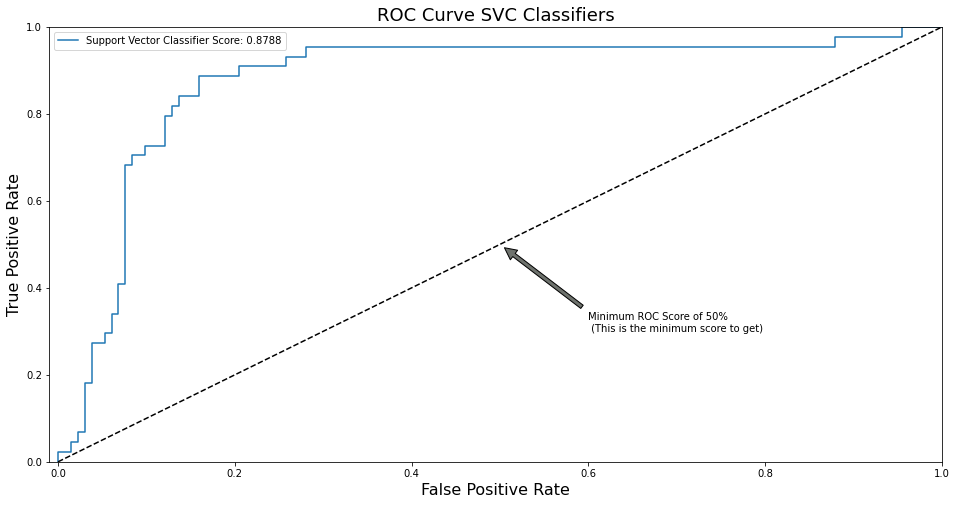

In [1468]:
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)

def graph_roc_curve_multiple(svc_fpr, svc_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve SVC Classifiers', fontsize=18)
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(svc_fpr, svc_tpr)
plt.show()

# Subject 2

In [1469]:
df2 = generate_auth_dataset(df,2, ratio=3)
df2_test = generate_auth_dataset(df_test,2, ratio=3)

In [1470]:
scaler = StandardScaler()
X_Feat, y_train = df2.iloc[:, :-1].values, df2.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data2 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df2_test.iloc[:, :-1].values, df2_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test2 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data)
x_pca2 = pca.transform(scaled_data2)
x_pca2.shape


(192, 30)

In [1471]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test)
x_pca_test2 = pca.transform(scaled_data_test2)
x_pca_test2.shape

(96, 30)

In [1472]:
X_test = x_pca_test2
X_train = x_pca2

In [1473]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test2 = accuracy_score(y_test,predictions)

[[72  0]
 [24  0]]


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        72
           1       0.00      0.00      0.00        24

    accuracy                           0.75        96
   macro avg       0.38      0.50      0.43        96
weighted avg       0.56      0.75      0.64        96



## Subject 3

In [1474]:
df3 = generate_auth_dataset(df,3, ratio=3)
df3_test = generate_auth_dataset(df_test,3, ratio=3)

In [1475]:
scaler = StandardScaler()
X_Feat, y_train = df3.iloc[:, :-1].values, df3.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data3 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df3_test.iloc[:, :-1].values, df3_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test3 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data)
x_pca3 = pca.transform(scaled_data3)
x_pca3.shape


(188, 30)

In [1476]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test)
x_pca_test3 = pca.transform(scaled_data_test3)
x_pca_test3.shape

(96, 30)

In [1477]:
X_test = x_pca_test3
X_train = x_pca3

In [1478]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test3 = accuracy_score(y_test,predictions)

[[37 35]
 [24  0]]


              precision    recall  f1-score   support

           0       0.61      0.51      0.56        72
           1       0.00      0.00      0.00        24

    accuracy                           0.39        96
   macro avg       0.30      0.26      0.28        96
weighted avg       0.45      0.39      0.42        96



In [1479]:
df4 = generate_auth_dataset(df,4, ratio=3)
df4_test = generate_auth_dataset(df_test,4, ratio=3)

In [1480]:
scaler = StandardScaler()
X_Feat, y_train = df4.iloc[:, :-1].values, df4.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data4 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df4_test.iloc[:, :-1].values, df4_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test4 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data4)
x_pca4 = pca.transform(scaled_data4)
x_pca4.shape


(176, 30)

In [1481]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test4)
x_pca_test4 = pca.transform(scaled_data_test4)
x_pca_test4.shape

(56, 30)

In [1482]:
X_test = x_pca_test4
X_train = x_pca4

In [1483]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test4 = accuracy_score(y_test,predictions)

[[42  0]
 [13  1]]


              precision    recall  f1-score   support

           0       0.76      1.00      0.87        42
           1       1.00      0.07      0.13        14

    accuracy                           0.77        56
   macro avg       0.88      0.54      0.50        56
weighted avg       0.82      0.77      0.68        56



In [1484]:
df5 = generate_auth_dataset(df,5, ratio=3)
df5_test = generate_auth_dataset(df_test,5, ratio=3)

In [1485]:
scaler = StandardScaler()
X_Feat, y_train = df5.iloc[:, :-1].values, df5.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data5 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df5_test.iloc[:, :-1].values, df5_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test5 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data5)
x_pca5 = pca.transform(scaled_data5)
x_pca5.shape

(192, 30)

In [1486]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test5)
x_pca_test5 = pca.transform(scaled_data_test5)
x_pca_test5.shape

(96, 30)

In [1487]:
X_test = x_pca_test5
X_train = x_pca5

In [1488]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test5 = accuracy_score(y_test,predictions)

[[71  1]
 [24  0]]


              precision    recall  f1-score   support

           0       0.75      0.99      0.85        72
           1       0.00      0.00      0.00        24

    accuracy                           0.74        96
   macro avg       0.37      0.49      0.43        96
weighted avg       0.56      0.74      0.64        96



In [1489]:
df6 = generate_auth_dataset(df,6, ratio=3)
df6_test = generate_auth_dataset(df_test,6, ratio=3)

In [1490]:
scaler = StandardScaler()
X_Feat, y_train = df6.iloc[:, :-1].values, df6.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data6 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df6_test.iloc[:, :-1].values, df6_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test6 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data6)
x_pca6 = pca.transform(scaled_data6)
x_pca6.shape

(192, 30)

In [1491]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test6)
x_pca_test6 = pca.transform(scaled_data_test6)
x_pca_test6.shape

(96, 30)

In [1492]:
X_test = x_pca_test6
X_train = x_pca6

In [1493]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test6 = accuracy_score(y_test,predictions)

[[70  2]
 [24  0]]


              precision    recall  f1-score   support

           0       0.74      0.97      0.84        72
           1       0.00      0.00      0.00        24

    accuracy                           0.73        96
   macro avg       0.37      0.49      0.42        96
weighted avg       0.56      0.73      0.63        96



In [1494]:
df7 = generate_auth_dataset(df,7, ratio=3)
df7_test = generate_auth_dataset(df_test,7, ratio=3)

In [1495]:
scaler = StandardScaler()
X_Feat, y_train = df7.iloc[:, :-1].values, df7.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data7 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df7_test.iloc[:, :-1].values, df7_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test7 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data7)
x_pca7 = pca.transform(scaled_data7)
x_pca7.shape

(192, 30)

In [1496]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test7)
x_pca_test7 = pca.transform(scaled_data_test7)
x_pca_test7.shape

(96, 30)

In [1497]:
X_test = x_pca_test7
X_train = x_pca7

In [1498]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test7 = accuracy_score(y_test,predictions)

[[71  1]
 [24  0]]


              precision    recall  f1-score   support

           0       0.75      0.99      0.85        72
           1       0.00      0.00      0.00        24

    accuracy                           0.74        96
   macro avg       0.37      0.49      0.43        96
weighted avg       0.56      0.74      0.64        96



In [1499]:
df8 = generate_auth_dataset(df,8, ratio=3)
df8_test = generate_auth_dataset(df_test,8, ratio=3)

In [1500]:
scaler = StandardScaler()
X_Feat, y_train = df8.iloc[:, :-1].values, df8.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data8 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df8_test.iloc[:, :-1].values, df8_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test8 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data8)
x_pca8 = pca.transform(scaled_data8)
x_pca8.shape

(192, 30)

In [1501]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test8)
x_pca_test8 = pca.transform(scaled_data_test8)
x_pca_test8.shape

(96, 30)

In [1502]:
X_test = x_pca_test8
X_train = x_pca8

In [1503]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test8 = accuracy_score(y_test,predictions)

[[53 19]
 [24  0]]


              precision    recall  f1-score   support

           0       0.69      0.74      0.71        72
           1       0.00      0.00      0.00        24

    accuracy                           0.55        96
   macro avg       0.34      0.37      0.36        96
weighted avg       0.52      0.55      0.53        96



In [1504]:
df9 = generate_auth_dataset(df,9, ratio=3)
df9_test = generate_auth_dataset(df_test,9, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df9.iloc[:, :-1].values, df9.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data9 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df9_test.iloc[:, :-1].values, df9_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test9 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data9)
x_pca9 = pca.transform(scaled_data9)

pca = PCA(n_components=30)
pca.fit(scaled_data_test9)
x_pca_test9 = pca.transform(scaled_data_test9)

X_test = x_pca_test9
X_train = x_pca9

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test9 = accuracy_score(y_test,predictions)

[[67  5]
 [22  2]]


              precision    recall  f1-score   support

           0       0.75      0.93      0.83        72
           1       0.29      0.08      0.13        24

    accuracy                           0.72        96
   macro avg       0.52      0.51      0.48        96
weighted avg       0.64      0.72      0.66        96



In [1505]:
df10 = generate_auth_dataset(df,10, ratio=3)
df10_test = generate_auth_dataset(df_test,10, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df10.iloc[:, :-1].values, df10.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data10 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df10_test.iloc[:, :-1].values, df10_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test10 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data10)
x_pca10 = pca.transform(scaled_data10)

pca = PCA(n_components=30)
pca.fit(scaled_data_test10)
x_pca_test10 = pca.transform(scaled_data_test10)

X_test = x_pca_test10
X_train = x_pca10

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test10 = accuracy_score(y_test,predictions)

[[64  2]
 [22  0]]


              precision    recall  f1-score   support

           0       0.74      0.97      0.84        66
           1       0.00      0.00      0.00        22

    accuracy                           0.73        88
   macro avg       0.37      0.48      0.42        88
weighted avg       0.56      0.73      0.63        88



In [1506]:
df11 = generate_auth_dataset(df,11, ratio=3)
df11_test = generate_auth_dataset(df_test,11, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df11.iloc[:, :-1].values, df11.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data11 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df11_test.iloc[:, :-1].values, df11_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test11 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data11)
x_pca11 = pca.transform(scaled_data11)

pca = PCA(n_components=30)
pca.fit(scaled_data_test11)
x_pca_test11 = pca.transform(scaled_data_test11)

X_test = x_pca_test11
X_train = x_pca11

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test11 = accuracy_score(y_test,predictions)

[[64  8]
 [23  1]]


              precision    recall  f1-score   support

           0       0.74      0.89      0.81        72
           1       0.11      0.04      0.06        24

    accuracy                           0.68        96
   macro avg       0.42      0.47      0.43        96
weighted avg       0.58      0.68      0.62        96



In [1507]:
df12 = generate_auth_dataset(df,12, ratio=3)
df12_test = generate_auth_dataset(df_test,12, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df12.iloc[:, :-1].values, df12.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data12 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df12_test.iloc[:, :-1].values, df12_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test12 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data12)
x_pca12 = pca.transform(scaled_data12)

pca = PCA(n_components=30)
pca.fit(scaled_data_test12)
x_pca_test12 = pca.transform(scaled_data_test12)

X_test = x_pca_test12
X_train = x_pca12

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test12 = accuracy_score(y_test,predictions)

[[71  1]
 [18  6]]


              precision    recall  f1-score   support

           0       0.80      0.99      0.88        72
           1       0.86      0.25      0.39        24

    accuracy                           0.80        96
   macro avg       0.83      0.62      0.63        96
weighted avg       0.81      0.80      0.76        96



In [1508]:
df13 = generate_auth_dataset(df,13, ratio=3)
df13_test = generate_auth_dataset(df_test,13, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df13.iloc[:, :-1].values, df13.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data13 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df13_test.iloc[:, :-1].values, df13_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test13 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data13)
x_pca13 = pca.transform(scaled_data13)

pca = PCA(n_components=30)
pca.fit(scaled_data_test13)
x_pca_test13 = pca.transform(scaled_data_test13)

X_test = x_pca_test13
X_train = x_pca13

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test13 = accuracy_score(y_test,predictions)

[[63  9]
 [21  3]]


              precision    recall  f1-score   support

           0       0.75      0.88      0.81        72
           1       0.25      0.12      0.17        24

    accuracy                           0.69        96
   macro avg       0.50      0.50      0.49        96
weighted avg       0.62      0.69      0.65        96



In [1509]:
df14 = generate_auth_dataset(df,14, ratio=3)
df14_test = generate_auth_dataset(df_test,14, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df14.iloc[:, :-1].values, df14.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data14 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df14_test.iloc[:, :-1].values, df14_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test14 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data14)
x_pca14 = pca.transform(scaled_data14)

pca = PCA(n_components=30)
pca.fit(scaled_data_test14)
x_pca_test14 = pca.transform(scaled_data_test14)

X_test = x_pca_test14
X_train = x_pca14

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test14 = accuracy_score(y_test,predictions)

[[71  1]
 [23  1]]


              precision    recall  f1-score   support

           0       0.76      0.99      0.86        72
           1       0.50      0.04      0.08        24

    accuracy                           0.75        96
   macro avg       0.63      0.51      0.47        96
weighted avg       0.69      0.75      0.66        96



In [1510]:
df15 = generate_auth_dataset(df,15, ratio=3)
df15_test = generate_auth_dataset(df_test,15, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df15.iloc[:, :-1].values, df15.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data15 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df15_test.iloc[:, :-1].values, df15_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test15 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data15)
x_pca15 = pca.transform(scaled_data15)

pca = PCA(n_components=30)
pca.fit(scaled_data_test15)
x_pca_test15 = pca.transform(scaled_data_test15)

X_test = x_pca_test15
X_train = x_pca15

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test15 = accuracy_score(y_test,predictions)

[[69  3]
 [22  2]]


              precision    recall  f1-score   support

           0       0.76      0.96      0.85        72
           1       0.40      0.08      0.14        24

    accuracy                           0.74        96
   macro avg       0.58      0.52      0.49        96
weighted avg       0.67      0.74      0.67        96



In [1511]:
df16 = generate_auth_dataset(df,16, ratio=3)
df16_test = generate_auth_dataset(df_test,16, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df16.iloc[:, :-1].values, df16.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data16 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df16_test.iloc[:, :-1].values, df16_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test16 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data16)
x_pca16 = pca.transform(scaled_data16)

pca = PCA(n_components=30)
pca.fit(scaled_data_test16)
x_pca_test16 = pca.transform(scaled_data_test16)

X_test = x_pca_test16
X_train = x_pca16

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test16 = accuracy_score(y_test,predictions)

[[66  6]
 [10 14]]


              precision    recall  f1-score   support

           0       0.87      0.92      0.89        72
           1       0.70      0.58      0.64        24

    accuracy                           0.83        96
   macro avg       0.78      0.75      0.76        96
weighted avg       0.83      0.83      0.83        96



In [1512]:
df17 = generate_auth_dataset(df,17, ratio=3)
df17_test = generate_auth_dataset(df_test,17, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df17.iloc[:, :-1].values, df17.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data17 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df17_test.iloc[:, :-1].values, df17_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test17 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data17)
x_pca17 = pca.transform(scaled_data17)

pca = PCA(n_components=30)
pca.fit(scaled_data_test17)
x_pca_test17 = pca.transform(scaled_data_test17)

X_test = x_pca_test17
X_train = x_pca17

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test17 = accuracy_score(y_test,predictions)

[[68  4]
 [23  1]]


              precision    recall  f1-score   support

           0       0.75      0.94      0.83        72
           1       0.20      0.04      0.07        24

    accuracy                           0.72        96
   macro avg       0.47      0.49      0.45        96
weighted avg       0.61      0.72      0.64        96



In [1513]:
df18 = generate_auth_dataset(df,18, ratio=3)
df18_test = generate_auth_dataset(df_test,18, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df18.iloc[:, :-1].values, df18.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data18 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df18_test.iloc[:, :-1].values, df18_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test18 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data18)
x_pca18 = pca.transform(scaled_data18)

pca = PCA(n_components=30)
pca.fit(scaled_data_test18)
x_pca_test18 = pca.transform(scaled_data_test18)

X_test = x_pca_test18
X_train = x_pca18

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test18 = accuracy_score(y_test,predictions)

[[55 17]
 [24  0]]


              precision    recall  f1-score   support

           0       0.70      0.76      0.73        72
           1       0.00      0.00      0.00        24

    accuracy                           0.57        96
   macro avg       0.35      0.38      0.36        96
weighted avg       0.52      0.57      0.55        96



In [1514]:
df19 = generate_auth_dataset(df,19, ratio=3)
df19_test = generate_auth_dataset(df_test,19, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df19.iloc[:, :-1].values, df19.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data19 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df19_test.iloc[:, :-1].values, df19_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test19 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data19)
x_pca19 = pca.transform(scaled_data19)

pca = PCA(n_components=30)
pca.fit(scaled_data_test19)
x_pca_test19 = pca.transform(scaled_data_test19)

X_test = x_pca_test19
X_train = x_pca19

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test19 = accuracy_score(y_test,predictions)

[[67  5]
 [ 0 24]]


              precision    recall  f1-score   support

           0       1.00      0.93      0.96        72
           1       0.83      1.00      0.91        24

    accuracy                           0.95        96
   macro avg       0.91      0.97      0.93        96
weighted avg       0.96      0.95      0.95        96



In [1515]:
df20 = generate_auth_dataset(df,20, ratio=3)
df20_test = generate_auth_dataset(df_test,20, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df20.iloc[:, :-1].values, df20.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data20 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df20_test.iloc[:, :-1].values, df20_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test20 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data20)
x_pca20 = pca.transform(scaled_data20)

pca = PCA(n_components=30)
pca.fit(scaled_data_test20)
x_pca_test20 = pca.transform(scaled_data_test20)

X_test = x_pca_test20
X_train = x_pca20

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)


print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test20 = accuracy_score(y_test,predictions)

[[57  0]
 [19  0]]


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        57
           1       0.00      0.00      0.00        19

    accuracy                           0.75        76
   macro avg       0.38      0.50      0.43        76
weighted avg       0.56      0.75      0.64        76



In [1516]:
df21 = generate_auth_dataset(df,21, ratio=3)
df21_test = generate_auth_dataset(df_test,21, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df21.iloc[:, :-1].values, df21.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data21 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df21_test.iloc[:, :-1].values, df21_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test21 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data21)
x_pca21 = pca.transform(scaled_data21)

pca = PCA(n_components=30)
pca.fit(scaled_data_test21)
x_pca_test21 = pca.transform(scaled_data_test21)

X_test = x_pca_test21
X_train = x_pca21

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test21 = accuracy_score(y_test,predictions)

[[70  2]
 [23  1]]


              precision    recall  f1-score   support

           0       0.75      0.97      0.85        72
           1       0.33      0.04      0.07        24

    accuracy                           0.74        96
   macro avg       0.54      0.51      0.46        96
weighted avg       0.65      0.74      0.65        96



In [1517]:
data = {'Score Name 10':['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6','Subject 7', 'Subject 8', 'Subject 9', 'Subject 10', 'Subject 11', 'Subject 12', 'Subject 13', 'Subject 14', 'Subject 15', 'Subject 16', 'Subject 17', 'Subject 18', 'Subject 19', 'Subject 20', 'Subject 21'],
        'Scores 10':[score_test1*100, score_test2*100, score_test3*100, score_test4*100, score_test5*100, score_test6*100, score_test7*100, score_test8*100, score_test9*100, score_test10*100, score_test11*100, score_test12*100, score_test13*100, score_test14*100, score_test15*100, score_test16*100, score_test17*100, score_test18*100, score_test19*100, score_test20*100, score_test21*100]}

df_score = pd.DataFrame(data)
#df_score.set_index('Score Name 10', inplace=True)    
df_score_round1 = df_score.copy()
df_score_round2 = df_score.copy()
df_score_round3 = df_score.copy()
df_score_round4 = df_score.copy()
df_score_round5 = df_score.copy()
df_score_round6 = df_score.copy()
df_score_round7 = df_score.copy()
df_score_round8 = df_score.copy()
df_score_round9 = df_score.copy()
df_score_round10 = df_score.copy()

In [1518]:
result = pd.concat([df_score_round1,df_score_round2,df_score_round3,df_score_round4,df_score_round5,df_score_round6,df_score_round7,df_score_round8,df_score_round9,df_score_round10], axis=1)
result

,Scores 1,Scores 2,Scores 3,Scores 4,Scores 5,Scores 6,Scores 7,Scores 8,Scores 9,Scores 10
Subject 1,65.625000,69.791667,67.708333,71.875000,68.750000,70.833333,72.916667,71.875000,72.916667,68.750000
Subject 2,75.000000,70.833333,65.625000,63.541667,64.583333,72.916667,67.708333,70.833333,69.791667,75.000000
Subject 3,52.083333,40.625000,57.291667,56.250000,61.458333,43.750000,51.041667,58.333333,58.333333,38.541667
Subject 4,64.285714,73.214286,69.642857,69.642857,64.285714,71.428571,64.285714,75.000000,73.214286,76.785714
Subject 5,75.000000,73.958333,75.000000,73.958333,73.958333,75.000000,75.000000,75.000000,71.875000,73.958333
Subject 6,72.916667,75.000000,70.833333,71.875000,78.125000,75.000000,73.958333,73.958333,77.083333,72.916667
Subject 7,70.833333,75.000000,73.958333,75.000000,73.958333,73.958333,76.041667,70.833333,67.708333,73.958333
Subject 8,65.625000,66.666667,64.583333,58.333333,62.500000,62.500000,58.333333,57.291667,61.458333,55.208333
Subject 9,72.916667,70.833333,57.291667,80.208333,72.916667,65.625000,90.625000,78.125000,76.041667,71.875000
Subject 10,71.590909,68.181818,73.863636,75.000000,69.318182,70.454545,67.045455,75.000000,73.863636,72.727273


In [1519]:
s1 = result.iloc[0].mean()
s2 = result.iloc[1].mean()
s3 = result.iloc[2].mean()
s4 = result.iloc[3].mean()
s5 = result.iloc[4].mean()
s6 = result.iloc[5].mean()
s7 = result.iloc[6].mean()
s8 = result.iloc[7].mean()
s9 = result.iloc[8].mean()
s10 = result.iloc[9].mean()
s11 = result.iloc[10].mean()
s12 = result.iloc[11].mean()
s13 = result.iloc[12].mean()
s14 = result.iloc[13].mean()
s15 = result.iloc[14].mean()
s16 = result.iloc[15].mean()
s17 = result.iloc[16].mean()
s18 = result.iloc[17].mean()
s19 = result.iloc[18].mean()
s20 = result.iloc[19].mean()
s21 = result.iloc[20].mean()

In [1523]:
test_result = pd.DataFrame({'Stimulus 1': [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21]})
test_result.transpose()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Stimulus 1,70.104167,69.583333,51.770833,70.178571,74.270833,74.166667,73.125,61.25,73.645833,71.704545,...,72.5,72.291667,73.75,72.708333,73.75,69.479167,61.666667,80.416667,73.157895,70.833333


# STATISTICAL TEST

In [1524]:
test_result2 = pd.DataFrame({'Stimulus 2': [71.358696,79.146341,71.646341,73.586957,72.445652,71.684783,82.119565,72.119565,71.847826,67.445652,68.967391,78.913043,80.217391,68.967391,72.934783,84.021739,72.663043,57.663043,72.500000,73.977273,76.576087]})
test_result2.transpose()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Stimulus 2,71.358696,79.146341,71.646341,73.586957,72.445652,71.684783,82.119565,72.119565,71.847826,67.445652,...,78.913043,80.217391,68.967391,72.934783,84.021739,72.663043,57.663043,72.5,73.977273,76.576087


In [1529]:
statistical_test = pd.DataFrame({'Stimulus 1': [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21],'Stimulus 2': [71.358696,79.146341,71.646341,73.586957,72.445652,71.684783,82.119565,72.119565,71.847826,67.445652,68.967391,78.913043,80.217391,68.967391,72.934783,84.021739,72.663043,57.663043,72.500000,73.977273,76.576087]})
statistical_test.transpose()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Stimulus 1,70.104167,69.583333,51.770833,70.178571,74.270833,74.166667,73.125000,61.250000,73.645833,71.704545,...,72.500000,72.291667,73.750000,72.708333,73.750000,69.479167,61.666667,80.416667,73.157895,70.833333
Stimulus 2,71.358696,79.146341,71.646341,73.586957,72.445652,71.684783,82.119565,72.119565,71.847826,67.445652,...,78.913043,80.217391,68.967391,72.934783,84.021739,72.663043,57.663043,72.500000,73.977273,76.576087


In [1531]:
df_statistics = statistical_test.transpose().copy()
df_statistics

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Stimulus 1,70.104167,69.583333,51.770833,70.178571,74.270833,74.166667,73.125000,61.250000,73.645833,71.704545,...,72.500000,72.291667,73.750000,72.708333,73.750000,69.479167,61.666667,80.416667,73.157895,70.833333
Stimulus 2,71.358696,79.146341,71.646341,73.586957,72.445652,71.684783,82.119565,72.119565,71.847826,67.445652,...,78.913043,80.217391,68.967391,72.934783,84.021739,72.663043,57.663043,72.500000,73.977273,76.576087


In [1575]:
df_dist = df_statistics.transpose()

In [1543]:
import seaborn as sns

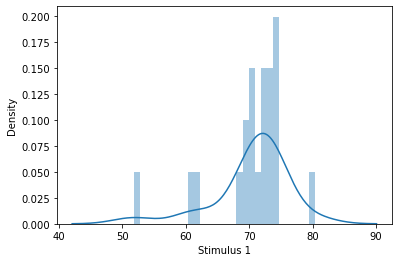

In [1548]:
tips = sns.distplot(df_dist['Stimulus 1'],bins=30)

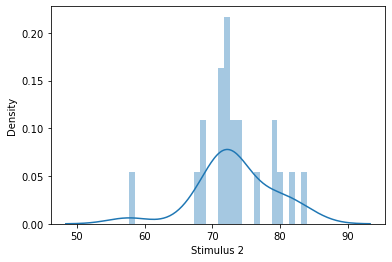

In [1547]:
tipss = sns.distplot(df_dist['Stimulus 2'],bins=30)

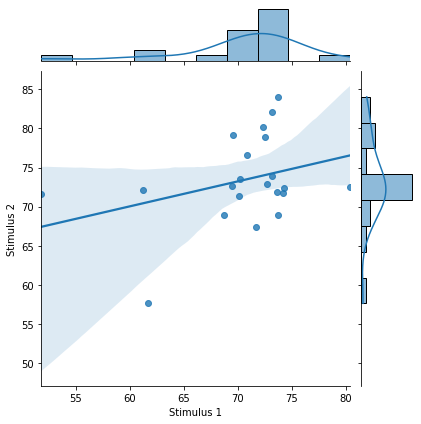

In [1551]:
sns.jointplot(x='Stimulus 1',y='Stimulus 2',data=df_dist,kind='reg')

# WILCOXON TEST

In [1552]:
wilcoxon_test = df_dist.copy()
wilcoxon_test

,Stimulus 1,Stimulus 2
0,70.104167,71.358696
1,69.583333,79.146341
2,51.770833,71.646341
3,70.178571,73.586957
4,74.270833,72.445652
5,74.166667,71.684783
6,73.125000,82.119565
7,61.250000,72.119565
8,73.645833,71.847826
9,71.704545,67.445652


In [1566]:
from scipy.stats import wilcoxon

### ASSUMING THE TWO STIMULUS ARE DIFFERENT WITH WILCOXON

In [1567]:
wilcoxon(wilcoxon_test['Stimulus 1'], wilcoxon_test['Stimulus 2'], correction=False)

WilcoxonResult(statistic=66.0, pvalue=0.08879852294921875)

### With a P-Value of 0.08.:
### H0 = There is No statistical difference between Stimulus 1 and Stimulus 2  | There is No Evidence to reject H0
### HA = Reject the Alternate Hypothesis that Stimulus 1 and Stimulus 2 are the same.

# T-Test 

In [1573]:
from scipy import stats

In [1580]:
stats.ttest_ind(wilcoxon_test['Stimulus 1'], wilcoxon_test['Stimulus 2'],equal_var=False)

Ttest_indResult(statistic=-1.6373050838590408, pvalue=0.10942458424108646)

### With a P-Value of 0.1094
### H0 = There is NO Statistical Difference between Stimulus 1 and Stimulus 2
### H1 = Reject the Alternate Hypothesis that Stimulus 1 and Stimulus 2 are the same.